In [1]:
import fastbook
fastbook.setup_book()
from utils import *
from fastbook import *

Step 1: Download images of birds and non-birds

In [2]:
urls = search_images_ddg('bird photos', max_images=1)
urls[0]

'http://www.hdnicewallpapers.com/Walls/Big/Other%20Birds/Beautiful_Kingfisher_Bird_Wallpaper.jpg'

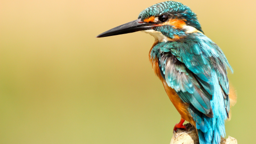

In [3]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

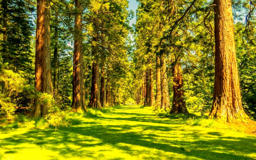

In [4]:
download_url(search_images_ddg('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images_ddg(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images_ddg(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Step 2: Train our model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

30

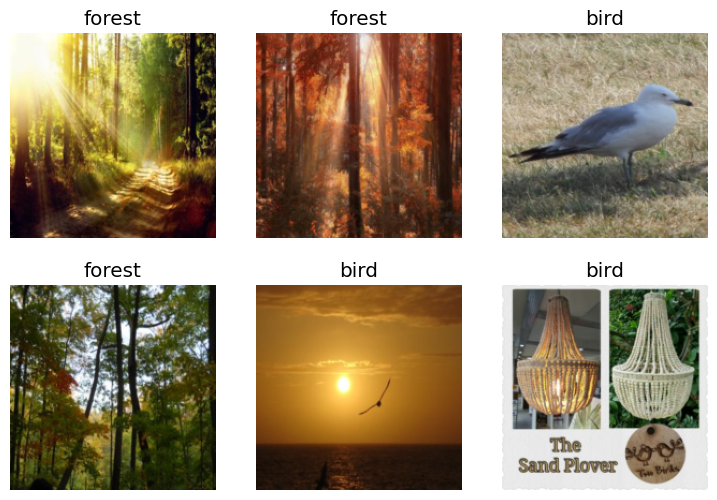

In [8]:


dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)



In [9]:
blocks=(ImageBlock, CategoryBlock),
blocks=(ImageBlock, CategoryBlock),
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=[Resize(192, method='squish')]


In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)


/home/asteroid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/asteroid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/asteroid/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.22MB/s]


In [15]:
is_bird,_,probs = learn.predict(PILImage.create('birds.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9973
